<a href="https://colab.research.google.com/github/sonbosung/Battery_SOH_Estimation/blob/master/RFB_SimpleRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 피클파일 복사
!cp "/content/drive/MyDrive/data/battery_data.pkl" "/content/battery_data.pkl"

In [3]:
# 피클파일 오픈
import pandas as pd
import pickle
f = open("battery_data.pkl", "rb")
df = pickle.load(f)
f.close

<function BufferedReader.close>

In [4]:
# 잘 불러와졌는지 확인
df

,단계_번호,인덱스,사이클_번호,전류(A),전압(V),보조전압1(V),보조전압2(V),보조전압3(V),온도('C),OCP(V),파워(W),부하(Ohm),누적_용량(Ah),절대값_용량(Ah),전류_범위,test_time,cycle_time,level_time
0,1,1,1,0.479619,1.173039,0,0,0,0,1.173039,0.562612,2.445772,0.000133,0.000133,1A,1.00,1.00,1.00
1,1,2,1,0.479619,1.180239,0,0,0,0,1.173039,0.566065,2.460784,0.000266,0.000266,1A,2.00,2.00,2.00
2,1,3,1,0.479557,1.183150,0,0,0,0,1.173039,0.567388,2.467173,0.000400,0.000400,1A,3.00,3.00,3.00
3,1,4,1,0.479588,1.184682,0,0,0,0,1.173039,0.568159,2.470208,0.000533,0.000533,1A,4.00,4.00,4.00
4,1,5,1,0.479588,1.185754,0,0,0,0,1.173039,0.568674,2.472444,0.000666,0.000666,1A,5.00,5.00,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262402,2,262403,510,-0.479806,0.868481,0,0,0,0,1.380010,-0.416702,-1.810067,0.440094,0.023989,1A,261897.83,365.92,180.00
262403,2,262404,510,-0.479806,0.820530,0,0,0,0,1.380010,-0.393695,-1.710129,0.439961,0.024122,1A,261898.83,366.92,181.00
262404,2,262405,510,-0.479775,0.763080,0,0,0,0,1.380010,-0.366107,-1.590497,0.439827,0.024256,1A,261899.83,367.92,182.00
262405,2,262406,510,-0.479775,0.699503,0,0,0,0,1.380010,-0.335604,-1.457982,0.439709,0.024374,1A,261900.72,368.81,182.89


In [5]:
# df.to_excel('capstone.xlsx')

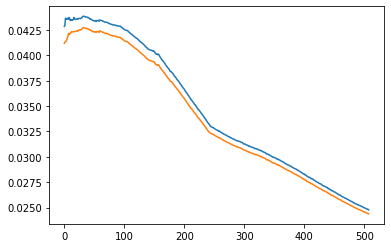

In [6]:
# 각 충방전 사이클마다 충전한 용량과 방전된 용량이 얼마인지 계산
total_cycles = df["사이클_번호"].iloc[-1]
charge_cap = []
discharge_cap = []
previous_charged_capacity = 0
previous_discharged_capacity = 0

for i in range(1, int(total_cycles+1)):
  # print(i)
  charge_df = df[(df["사이클_번호"]==i)&(df["단계_번호"]==1)]["누적_용량(Ah)"].to_list()
  discharge_df = df[(df["사이클_번호"]==i)&(df["단계_번호"]==2)]["누적_용량(Ah)"].to_list()
  charge_cap += [charge_df[-1] - previous_discharged_capacity]
  previous_charged_capacity = charge_df[-1]
  discharge_cap += [previous_charged_capacity - discharge_df[-1]]
  previous_discharged_capacity = discharge_df[-1]
  # print(charge_df[-1], discharge_df[-1])

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(charge_cap[2:])
plt.plot(discharge_cap[2:])
plt.show()

In [7]:
# expected nominal capacity of the battery
print(max(discharge_cap[20:60]))

0.042750121215811815


In [8]:
cycle_num = df["사이클_번호"].to_list()
cycle_cap = []
for i in range(len(df)):
  cycle_cap += [discharge_cap[cycle_num[i]-1]]

In [9]:
print(len(cycle_cap))
print(len(cycle_num))

262407
262407


In [10]:
df["cycle_capacity"] = cycle_cap

In [ ]:
# get sequence length
seq_len = []
for cycle in range(1, 510+1):
  cycle_len = len(df.loc[(df["사이클_번호"]==cycle)&(df["단계_번호"]==1)])
  print(cycle_len)
  seq_len += [cycle_len]

In [ ]:
print(seq_len)

In [13]:
# train data, validation data, test data 생성
# 510개의 train data 중 무작위 450개를 train data
#                             30 개를 validation data
#                             30 개를 test data로 설정


In [14]:
max_length = max(df[df["단계_번호"]==1]["사이클_번호"].value_counts().to_list())
print(max(df[df["단계_번호"]==1]["사이클_번호"].value_counts().to_list()))
print(max(df[df["단계_번호"]==2]["사이클_번호"].value_counts().to_list()))

585
321


In [15]:
# padding
import numpy as np
data_shape = (total_cycles,max_length,2)
X_train = np.zeros(shape=data_shape, dtype=np.float32)
y_train = np.array(discharge_cap, dtype=np.float32)
input_shape=(585, 2)
for cycle in range(1, total_cycles+1):
  vols, curs = [], []
  vols += (df.loc[(df["사이클_번호"]==cycle)&(df["단계_번호"]==1)]["전압(V)"].to_list())
  curs += (df.loc[(df["사이클_번호"]==cycle)&(df["단계_번호"]==1)]["전류(A)"].to_list())
  vols += ([0]*(max_length - seq_len[cycle - 1]))
  curs += ([0]*(max_length - seq_len[cycle - 1]))
  vols = np.array(vols, dtype=np.float32)
  curs = np.array(curs, dtype=np.float32)
  X_train[cycle-1, :, 0] = vols
  X_train[cycle-1, :, 1] = curs

In [16]:
# Data Normalization
# gaussian normalization 사용
v_mean, v_std = np.mean(X_train[:,:,0]), np.std(X_train[:,:,0])
i_mean, i_std = np.mean(X_train[:,:,1]), np.std(X_train[:,:,1])

X_train[:,:,0] = (X_train[:,:,0] - v_mean)/v_std
X_train[:,:,1] = (X_train[:,:,1] - i_mean)/i_std

In [ ]:
print(X_train)
print(y_train)
print("{}, {}".format(X_train.shape, y_train.shape))

In [18]:
import random

def data_generator(X_train, y_train):
  idx = np.random.shuffle(np.arange(510))
  X_train, y_train = X_train[idx,:,:].reshape(-1,585,2), y_train[idx].reshape(-1)
  X_tr, y_tr = X_train[0:450,:,:], y_train[0:450]
  X_val, y_val = X_train[450:480,:,:], y_train[450:480]
  X_te, y_te = X_train[480:510,:,:], y_train[480:510]
  return (X_tr, y_tr, X_val, y_val, X_te, y_te)

In [19]:
(X_tr, y_tr, X_val, y_val, X_te, y_te) = data_generator(X_train, y_train)

In [20]:
print(X_tr.shape, y_tr.shape, X_val.shape, y_val.shape, X_te.shape, y_te.shape)

(450, 585, 2) (450,) (30, 585, 2) (30,) (30, 585, 2) (30,)


In [23]:
# 모델 정의
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(8, input_dim=2, input_length=max_length),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 8)                 88        
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 10)                90        
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 189
Trainable params: 189
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(x=X_tr, y=y_tr, epochs=50, batch_size=16, validation_data=(X_val, y_val),
                 shuffle=True, verbose=1)

Epoch 1/50
29/29 [==============================] - 3s 70ms/step - loss: 0.4142 - val_loss: 0.0083
Epoch 2/50
29/29 [==============================] - 3s 90ms/step - loss: 0.0601 - val_loss: 1.0130e-04
Epoch 3/50
29/29 [==============================] - 2s 65ms/step - loss: 0.0465 - val_loss: 2.3795e-04
Epoch 4/50
29/29 [==============================] - 2s 66ms/step - loss: 0.0297 - val_loss: 3.7210e-04
Epoch 5/50
29/29 [==============================] - 2s 65ms/step - loss: 0.0284 - val_loss: 1.7410e-05
Epoch 6/50
29/29 [==============================] - 2s 68ms/step - loss: 0.0197 - val_loss: 4.9338e-07
Epoch 7/50
29/29 [==============================] - 2s 76ms/step - loss: 0.0155 - val_loss: 3.7169e-05
Epoch 8/50
29/29 [==============================] - 2s 74ms/step - loss: 0.0133 - val_loss: 1.9566e-05
Epoch 9/50
29/29 [==============================] - 2s 78ms/step - loss: 0.0140 - val_loss: 1.2059e-04
Epoch 10/50
29/29 [==============================] - 2s 65ms/step - loss: 0.0

In [25]:
score = model.evaluate(X_te, y_te, verbose=1)

1/1 [==============================] - 0s 33ms/step - loss: 7.3702e-05


In [26]:
print(score)

7.370188541244715e-05


Text(0.5, 1.0, 'Simple RNN')

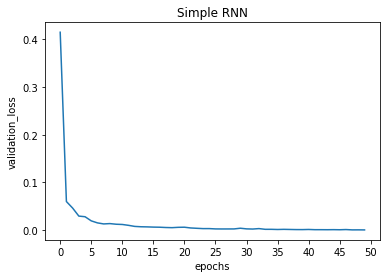

In [31]:
plt.plot(history.history["loss"])
plt.xticks(np.arange(0,51,5))
plt.xlabel("epochs")
plt.ylabel("validation_loss")
plt.title("Simple RNN")